# CoreAPI Walkthrough

### Table Of Contents
 1. Overview
 2. Initializing
 3. Quick setup with detached mode
 - logging metrics
 - including checkpointing
 - including distributed training
 4. Switching to managed mode
 - hyperparameter search


# 1. Overview

## What is CoreAPI?
Take your existing model training code, and adapt it using CoreAPI to get all the awesome MLDE features
## How do I use it?
You can start off quickly using detached mode where you can get your feet wet with some basic features with minimal code changes.

Next, create a config file and connect to the MLDE cluster to run fully managed experiments with the full feature set at your disposal.
### Detached Mode
- quick setup and model tracking

### Managed Mode
- switching to managed CoreAPI
- model tracking
- checkpointing
- distributed training
- hyperparameter search
- profiling

# 2. Initializing

### MLDE manager
We need to set up an environment that has determined installed to manage our cluster with.
You can do this by running python, and `pip install determined`.

Alternatively, start from a prebuilt docker image here https://hub.docker.com/r/determinedai/environments/tags?page=1.

### MLDE cluster
You need to either create or connect to a cluster in order to use it. From your manager, run `det deploy <platform> up` with either `local`, `aws`, or `gcp` to set up your cluster. 
Then you have to set the `DET_MASTER` env variable and login.
For this demo, we use an existing cluster.

### Basic example
To check that you've properly connected, you can run a quick job in detached mode. We include the code to do this below.

In [20]:
import random
from determined.experimental import core_v2 as core_context
import warnings
warnings.filterwarnings('ignore')

with core_context.init_context(defaults=core_context.DefaultConfig(name="basic_example")) as context:
    for i in range(100):
        # Report training metrics
        context.train.report_training_metrics(steps_completed=i, metrics={"loss": random.random()})

        # Report validation metrics every 10 steps
        if (i + 1) % 10 == 0:
            context.train.report_validation_metrics(steps_completed=i, metrics={"loss": random.random()})

## Viewing the example
Navigate to your cluster at `DET_MASTER`. You should login with the default credentials and be able to see your experiment from the home page:

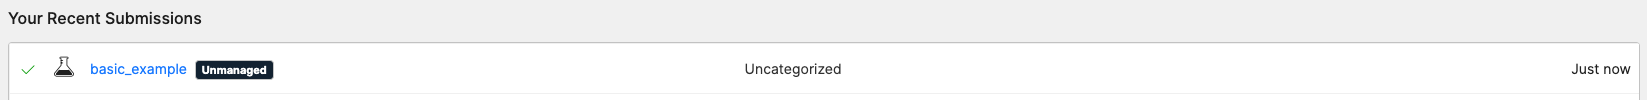

Clicking on it should show you the overview

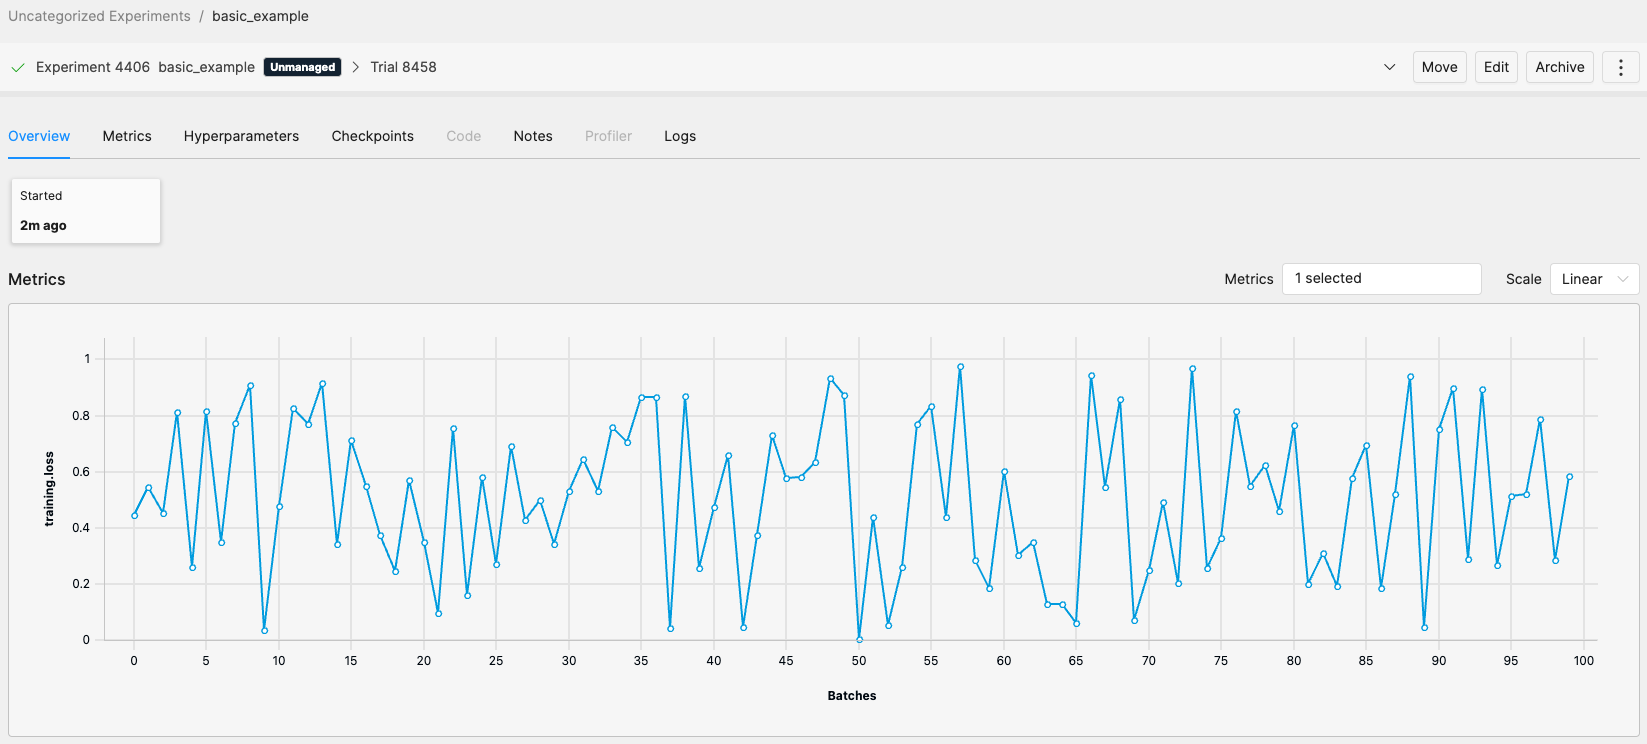

# 3. Quick setup from existing model code
We will now, with minimal changes, get an existing model training code tracking on the cluster.

This feature set mimics other experiment trackers like `mlflow` or `wandb`

The ONLY changes I have made are:
1. importing `core_context`
```python
from determined.experimental import core_v2 as core_context
```

2. adding a `steps completed` variable
```python
steps_completed=(batch_idx + 1) + epoch_idx * len(train_loader)
```
3. reporting training/validation metrics wherever the training loop exists (either in the for loop or in a callback)
```python
...[training loop]
core_context.train.report_training_metrics(
                steps_completed=steps_completed, 
                metrics={"train_loss": loss.item()}
            )

...[validation loop]
core_context.train.report_validation_metrics(
                steps_completed=steps_completed, 
                metrics={"test_loss": test_loss}
            )
```
Compare `base.py` and `metrics.py` to see the code differences.

### Viewing the output
After running the below cell, you should find `porting_example` from the `home` tab, and clicking on it should show the training run.

In [21]:
import determined as det
import torch
import utils, base, metrics, checkpoints
import uuid

hparams = {
    "epochs": 5,
    "batch_size": 64, 
    "test_batch_size": 1000,
    "learning_rate": 1e-4, 
    "gamma": 0.7,
    "n_filters1":8, 
    "n_filters2":8, 
    "dropout1":0.2, 
    "dropout2":0.2
}

device = torch.device("cuda")

with core_context.init_context(defaults=core_context.DefaultConfig(name="porting_example")) as context:  
    train_loader, test_loader   = base.setup_datasets(device, hparams)
    model, optimizer, scheduler = base.setup_models(device, hparams)

    # train while tracking metrics
    for epoch_idx in range(0, hparams["epochs"]):
        steps_completed = (epoch_idx+1) * len(train_loader)
        metrics.train(model, device, train_loader, optimizer, scheduler, context, epoch_idx)
        metrics.test( model, device,  test_loader, context, steps_completed=steps_completed)

Train Epoch: 0 [57536/60000 (96%)]	Loss: 2.295924
Test set: Average loss: 2.3126, Accuracy: 1030/10000 (10%)
Train Epoch: 1 [57536/60000 (96%)]	Loss: 2.295142
Test set: Average loss: 2.3126, Accuracy: 1030/10000 (10%)
Train Epoch: 2 [57536/60000 (96%)]	Loss: 2.302189
Test set: Average loss: 2.3126, Accuracy: 1030/10000 (10%)
Train Epoch: 3 [57536/60000 (96%)]	Loss: 2.291957
Test set: Average loss: 2.3126, Accuracy: 1030/10000 (10%)
Train Epoch: 4 [57536/60000 (96%)]	Loss: 2.301710
Test set: Average loss: 2.3126, Accuracy: 1030/10000 (10%)


## Including checkpointing
In some cases, you have access to the checkpoint file share that the determined cluster is using, usually if you're running a cluster through aws or gcp and the checkpoints are located in cloud storage. In this case, saving/loading checkpoints to the same location lets you easily add checkpointing to detached mode. This allows you to:
1. save checkpoints from experiments to use them for later
2. resume training easily from the last checkpoint if an experiment crashes or is paused

In [22]:
import utils, checkpoints

default_context, unmanaged_context = utils.core_setup() # specify the checkpoint directory and project/workspace to track runs
with core_context.init_context(defaults=default_context, unmanaged=unmanaged_context) as context:  
    train_loader, test_loader  = base.setup_datasets(device, hparams)
    model, optimizer, scheduler, epochs_completed = checkpoints.setup_models(device, hparams, context) # loading models from checkpoint

    # train while tracking metrics
    for epoch_idx in range(epochs_completed, hparams["epochs"]):
        steps_completed = (epoch_idx+1) * len(train_loader)
        metrics.train(model, device, train_loader, optimizer, scheduler, context, epoch_idx)
        metrics.test( model, device,  test_loader, context, steps_completed=steps_completed)
        
        # checkpointing is just torch.save() in the context manager
        with context.checkpoint.store_path({"steps_completed": steps_completed}) as (path, storage_id):
            torch.save(model.state_dict(), path / "checkpoint.pt")
            with (path / "state").open("w") as fout:
                fout.write(f"{epoch_idx+1},{context.info.trial.trial_id}")
        
        break # let's say training failed after the first epoch due to a power outage

loaded model from scratch
Train Epoch: 0 [57536/60000 (96%)]	Loss: 2.300451
Test set: Average loss: 2.2975, Accuracy: 985/10000 (10%)


In [23]:
with core_context.init_context(defaults=default_context, unmanaged=unmanaged_context) as context:  
    train_loader, test_loader  = base.setup_datasets(device, hparams)
    model, optimizer, scheduler, epochs_completed = checkpoints.setup_models(device, hparams, context)

    # train while tracking metrics
    for epoch_idx in range(epochs_completed, hparams["epochs"]):
        steps_completed = (epoch_idx+1) * len(train_loader)
        metrics.train(model, device, train_loader, optimizer, scheduler, context, epoch_idx)
        metrics.test( model, device,  test_loader, context, steps_completed=steps_completed)

        with context.checkpoint.store_path({"steps_completed": steps_completed}) as (path, storage_id):
            torch.save(model.state_dict(), path / "checkpoint.pt")
            with (path / "state").open("w") as fout:
                fout.write(f"{epoch_idx+1},{context.info.trial.trial_id}")

loaded model from checkpoint
resuming at epoch 1
Train Epoch: 1 [57536/60000 (96%)]	Loss: 2.290345
Test set: Average loss: 2.2975, Accuracy: 988/10000 (10%)
Train Epoch: 2 [57536/60000 (96%)]	Loss: 2.286693
Test set: Average loss: 2.2975, Accuracy: 988/10000 (10%)
Train Epoch: 3 [57536/60000 (96%)]	Loss: 2.286703
Test set: Average loss: 2.2975, Accuracy: 988/10000 (10%)
Train Epoch: 4 [57536/60000 (96%)]	Loss: 2.286574
Test set: Average loss: 2.2975, Accuracy: 988/10000 (10%)


# 4. Switching to managed mode
We've shown you how to experiment quickly on your own machines.
If you want to use the rest of the features, you can switch to the central cluster to leverage them
In order to fully leverage the features of Core API, we need to run each experiment with the determined runner. To do this, we have to
1. create a config.yaml with necessary fields defined
2. run `det e create <path to yaml> <path to code>` in the management environment

## The experiment config file
Each experiment uses a configuration file to track its state. 

In [24]:
!det e create config_basic.yaml . 

Preparing files to send to master... 378.3KB and 29 files
Created experiment 4965
